# JAReleases Exploratory Data Analysis

This notebook analyzes the `JAReleases` daily CSV logs to uncover trends in release times, bond markets, offense types, and court activity.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Load all JAReleases CSV files
files = sorted(glob.glob('JAReleases_*.csv'))
print(f"Found {len(files)} release files.")

dfs = []
for f in files:
    try:
        # Read CSV, ensuring string types for mixed columns to avoid warnings
        df = pd.read_csv(f, dtype={'BondAmount': str, 'CaseNumber': str})
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if dfs:
    data = pd.concat(dfs, ignore_index=True)
    print(f"Total records loaded: {len(data)}")
    print(data.head())
else:
    print("No data loaded.")

Found 26 release files.
Total records loaded: 4441
   SONumber                 InmateName  \
0   1001562      CASTILLO, LUIS ALVINO   
1   1022713    MERLO, OCTAVIA GONZALEZ   
2   1025087       EMMELE, DILLON SCOTT   
3   1032901  CHAMBERS, DENNIS MITCHELL   
4   1035805        MARTINEZ, JESSICA A   

                                      Address1   CaseNumber  \
0      418 E YOUNG AVE , SAN ANTONIO, TX 78214  2025PF48707   
1  4445 COMMERICAL AVE , San Antonio, TX 78221  2025PF43023   
2  314 LOMA VISTA ST , NEW BRAUNFELS, TX 78130          NaN   
3  10506 BLUESTONE CRK , SAN ANTONIO, TX 78254  2025PF50379   
4              HOMELESS, SAN ANTONIO, TX 78238  2025PF46093   

                      Court            AttorneyName ReleaseDate ReleaseTime  \
0  Criminal, District Court        Pollock, Julie B  12/20/2025     1:45 AM   
1      227th District Court          Dewalt, Eric A  12/20/2025     4:41 AM   
2                       NaN                     NaN  12/20/2025     8:11 PM   
3

## 2. Data Cleaning & Preprocessing
*   Convert `ReleaseDate` and `ReleaseTime` to datetime objects.
*   Clean `BondAmount` (remove non-numeric chars) and convert to float.
*   Extract Zip Codes from `Address1` for geospatial grouping.

In [2]:
# DateTime Conversion
data['ReleaseFullTime'] = pd.to_datetime(data['ReleaseDate'] + ' ' + data['ReleaseTime'], errors='coerce')
data['ReleaseDate_dt'] = pd.to_datetime(data['ReleaseDate'], errors='coerce')
data['OffenseDate_dt'] = pd.to_datetime(data['OffenseDate'], errors='coerce')

# Bond Amount Cleaning
def clean_currency(x):
    if pd.isna(x) or x == '': return 0.0
    if isinstance(x, str):
        return float(x.replace(',', '').replace('$', ''))
    return float(x)

data['BondAmount_Clean'] = data['BondAmount'].apply(clean_currency)

# Extract Zip Code (Simple regex for 5 digits at the end)
# Note: double backslash needed for JSON string encoding of the regex backslash
data['ZipCode'] = data['Address1'].astype(str).str.extract(r'(\d{5})')

print("Data Types after cleaning:")
print(data.dtypes)

Data Types after cleaning:
SONumber                       int64
InmateName                    object
Address1                      object
CaseNumber                    object
Court                         object
AttorneyName                  object
ReleaseDate                   object
ReleaseTime                   object
ReleaseType                   object
OffenseDescription            object
OffenseDate                   object
BondType                      object
BondAmount                    object
BondsmanName                  object
ReleaseFullTime       datetime64[ns]
ReleaseDate_dt        datetime64[ns]
OffenseDate_dt        datetime64[ns]
BondAmount_Clean             float64
ZipCode                       object
dtype: object


## 3. Temporal Analysis: Release Patterns
When do releases occur? Is there a bottleneck?

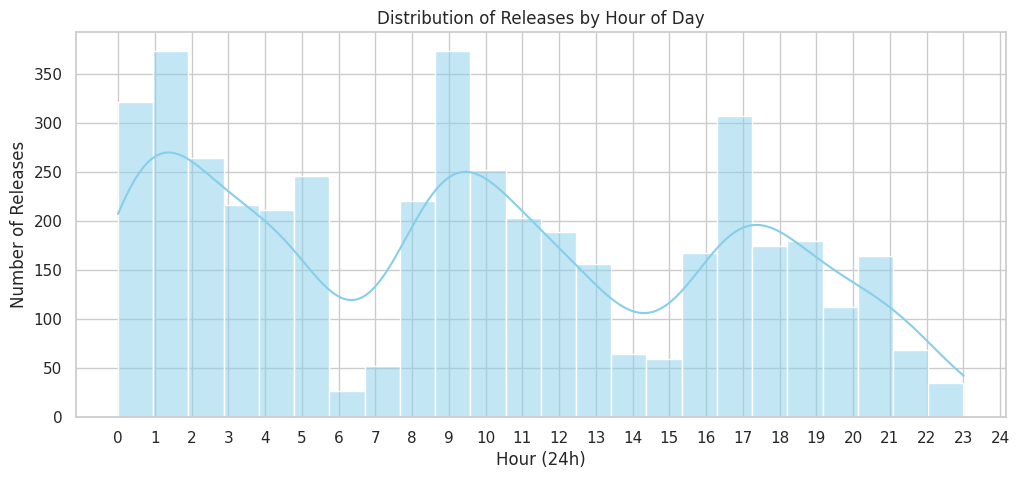

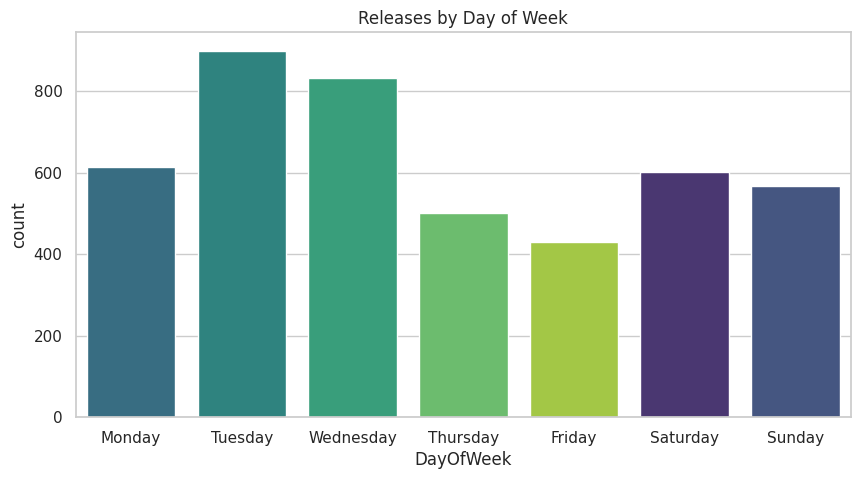

In [3]:
# Hourly Distribution
data['ReleaseHour'] = data['ReleaseFullTime'].dt.hour

plt.figure(figsize=(12, 5))
sns.histplot(data=data, x='ReleaseHour', bins=24, kde=True, color='skyblue')
plt.title('Distribution of Releases by Hour of Day')
plt.xlabel('Hour (24h)')
plt.ylabel('Number of Releases')
plt.xticks(range(0, 25))
plt.show()

# Day of Week Analysis
data['DayOfWeek'] = data['ReleaseFullTime'].dt.day_name()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='DayOfWeek', order=ordered_days, hue='DayOfWeek', legend=False, palette='viridis')
plt.title('Releases by Day of Week')
plt.show()

## 4. Financial Analysis: Bonds
Who are the major players in the surety market? What is the distribution of bond amounts?

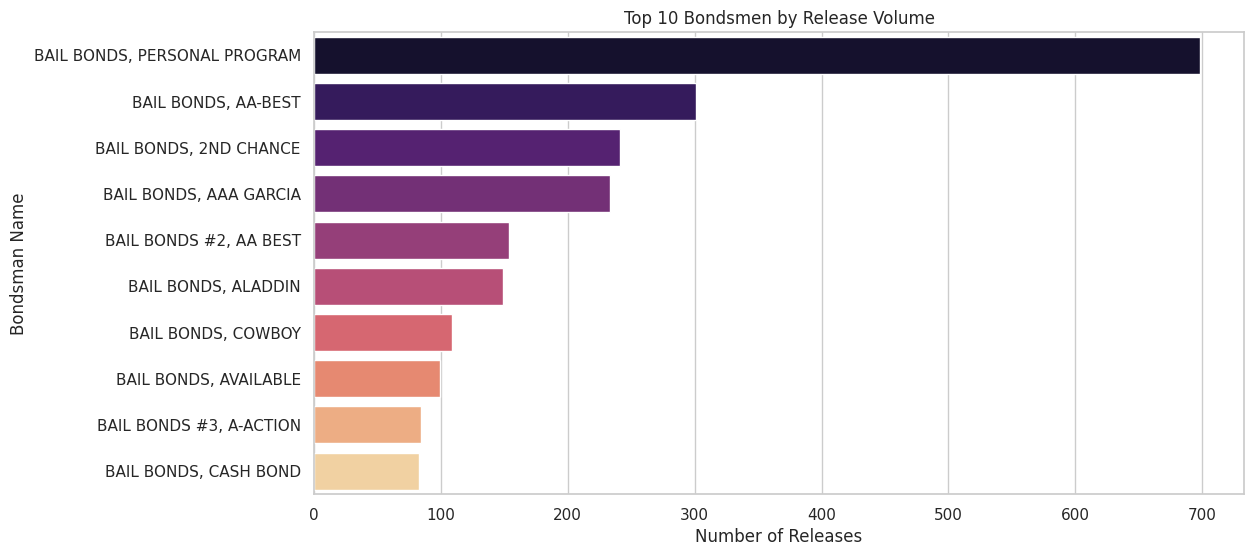

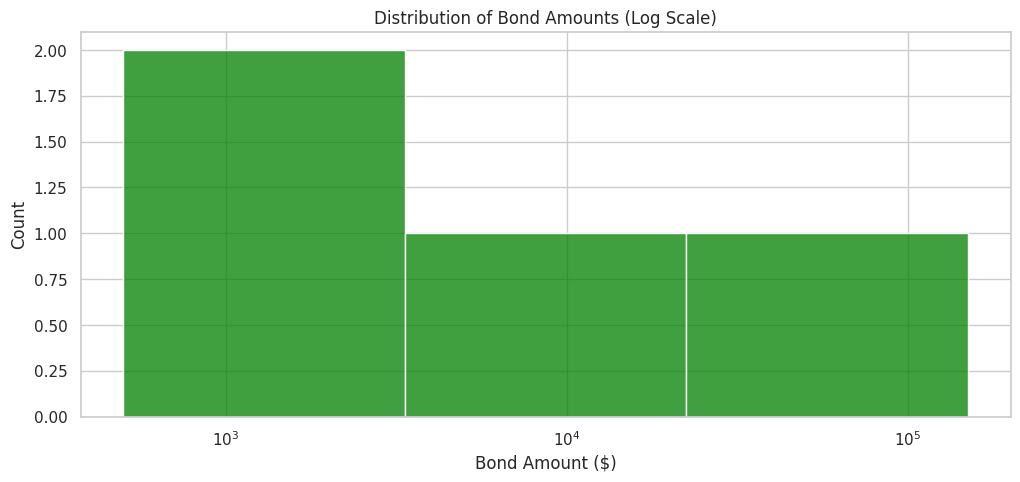

In [4]:
# Top Bondsmen by Volume
top_bondsmen = data['BondsmanName'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=top_bondsmen.index, x=top_bondsmen.values, hue=top_bondsmen.index, legend=False, palette='magma')
plt.title('Top 10 Bondsmen by Release Volume')
plt.xlabel('Number of Releases')
plt.ylabel('Bondsman Name')
plt.show()

# Bond Amount Distribution (Log Scale due to outliers)
plt.figure(figsize=(12, 5))
sns.histplot(data=data[data['BondAmount_Clean'] > 0], x='BondAmount_Clean', log_scale=True, color='green')
plt.title('Distribution of Bond Amounts (Log Scale)')
plt.xlabel('Bond Amount ($)')
plt.show()

## 5. Legal & Judicial Analytics
Which courts are most active? Who are the top defense attorneys?

In [5]:
# Top Courts
top_courts = data['Court'].value_counts().head(10)
print("Top 10 Active Courts:")
print(top_courts)

# Top Attorneys
top_attorneys = data['AttorneyName'].value_counts().head(10)
print("Top 10 Defense Attorneys:")
print(top_attorneys)

Top 10 Active Courts:
Court
Criminal, District Court    967
County Court-at-Law 7       248
County Court-at-Law 13      238
County Court-at-Law 5       174
County Court-at-Law 12      166
County Court-at-Law 9       154
County Court-at-Law 6       153
County Court-at-Law 2       152
County Court-at-Law 8       146
County Court-at-Law 11      138
Name: count, dtype: int64
Top 10 Defense Attorneys:
AttorneyName
Defender, Public               92
Hernandez, Tony                35
Garcia, Teresa                 33
Shaw, Lindsey C                33
Tocci, James Vincent           33
Garza, Abelardo                33
Butler, Milton Clifton, III    32
Cox, Cornelius Noel            32
Silver, Areli                  32
Eakle, Joanne                  31
Name: count, dtype: int64


## 6. Geospatial Proxy: Zip Code Analysis
Where are released individuals returning to?

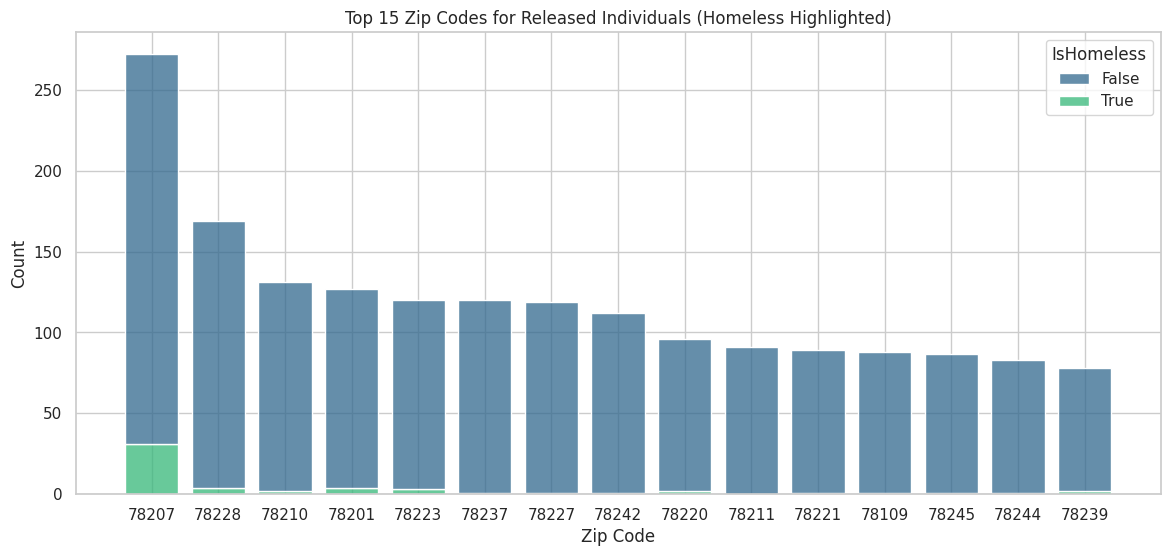

In [6]:
# Identify Homeless Records
data['IsHomeless'] = data['Address1'].astype(str).str.contains('HOMELESS', case=False, na=False)

top_zips_list = data['ZipCode'].value_counts().head(15).index
data_top_zips = data[data['ZipCode'].isin(top_zips_list)].copy()

# Sort bars from high to low by converting ZipCode to an ordered categorical type
data_top_zips['ZipCode'] = pd.Categorical(data_top_zips['ZipCode'], categories=top_zips_list, ordered=True)

plt.figure(figsize=(14, 6))
sns.histplot(data=data_top_zips, x='ZipCode', hue='IsHomeless', multiple='stack', shrink=.8, palette='viridis')
plt.title('Top 15 Zip Codes for Released Individuals (Homeless Highlighted)')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.show()

## 7. Interactive Mapping
Geocoding addresses via local Nominatim service (port 8095) and visualizing release locations.

In [7]:
import requests
import folium
from folium.plugins import MarkerCluster
import time

def geocode_address(address):
    """Geocode address using local Nominatim service."""
    url = "http://localhost:8095/search"
    params = {
        'q': address,
        'format': 'json',
        'limit': 1
    }
    try:
        response = requests.get(url, params=params, timeout=5)
        if response.status_code == 200 and response.json():
            res = response.json()[0]
            return float(res['lat']), float(res['lon'])
    except Exception as e:
        pass
    return None, None

# Geocode unique addresses to be efficient
unique_addresses = data['Address1'].unique()
print(f"Geocoding {len(unique_addresses)} unique addresses...")

geo_cache = {}
for i, addr in enumerate(unique_addresses):
    if addr and "HOMELESS" not in str(addr).upper():
        lat, lon = geocode_address(addr)
        if lat:
            geo_cache[addr] = (lat, lon)
    if i % 50 == 0: print(f"Processed {i}/{len(unique_addresses)}...")

# Map coordinates back to main dataframe
data['latitude'] = data['Address1'].map(lambda x: geo_cache.get(x, (None, None))[0])
data['longitude'] = data['Address1'].map(lambda x: geo_cache.get(x, (None, None))[1])

# Create Map centered on Bexar County
m = folium.Map(location=[29.4241, -98.4936], zoom_start=11)
marker_cluster = MarkerCluster().add_to(m)

for idx, row in data.dropna(subset=['latitude']).iterrows():
    color = 'red' if row['IsHomeless'] else 'blue'
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<b>Inmate:</b> {row.get('InmateName', 'Unknown')}<br><b>Address:</b> {row.get('Address1', 'Unknown')}<br><b>Offense:</b> {row.get('OffenseDescription', 'N/A')}<br><a href='https://www.google.com/maps/search/?api=1&query={row['latitude']},{row['longitude']}' target='_blank'>Open in Google Maps</a>",
        tooltip=str(row['Address1']),
        icon=folium.Icon(color=color)
    ).add_to(marker_cluster)

m.save('release_map.html')
print("Map saved to release_map.html")
m

Geocoding 2863 unique addresses...
Processed 0/2863...


Processed 50/2863...


Processed 100/2863...


Processed 150/2863...


Processed 200/2863...


Processed 250/2863...


Processed 300/2863...


Processed 350/2863...


Processed 400/2863...


Processed 450/2863...


Processed 500/2863...


Processed 550/2863...


Processed 600/2863...


Processed 650/2863...


Processed 700/2863...


Processed 750/2863...


Processed 800/2863...


Processed 850/2863...


Processed 900/2863...


Processed 950/2863...


Processed 1000/2863...


Processed 1050/2863...


Processed 1100/2863...


Processed 1150/2863...


Processed 1200/2863...


Processed 1250/2863...


Processed 1300/2863...


Processed 1350/2863...


Processed 1400/2863...


Processed 1450/2863...


Processed 1500/2863...


Processed 1550/2863...


Processed 1600/2863...


Processed 1650/2863...


Processed 1700/2863...


Processed 1750/2863...


Processed 1800/2863...


Processed 1850/2863...


Processed 1900/2863...


Processed 1950/2863...


Processed 2000/2863...


Processed 2050/2863...


Processed 2100/2863...


Processed 2150/2863...


Processed 2200/2863...


Processed 2250/2863...


Processed 2300/2863...


Processed 2350/2863...


Processed 2400/2863...


Processed 2450/2863...


Processed 2500/2863...


Processed 2550/2863...


Processed 2600/2863...


Processed 2650/2863...


Processed 2700/2863...


Processed 2750/2863...


Processed 2800/2863...


Processed 2850/2863...


Map saved to release_map.html
